In [2]:
# Core libraries
import numpy as np
import pandas as pd
import os
import inspect
import json
from pathlib import Path
from IPython.display import display, HTML
from typing import List, Dict, Tuple, Union, Optional, Any, Callable
import pickle
import json
import gc
# Machine learning
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             balanced_accuracy_score, log_loss,
                             roc_curve, ConfusionMatrixDisplay,
                             precision_recall_curve, confusion_matrix, matthews_corrcoef, roc_auc_score)
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# Hyperparameter tuning
import optuna
# 1) Silence Optuna’s default trial‐completion logs
optuna.logging.set_verbosity(optuna.logging.WARNING)      # only WARN and above
optuna.logging.disable_default_handler()                   # remove the stderr handler

# Explainability
import shap
try:
    from lime.lime_tabular import LimeTabularExplainer
    _lime_available = True
except ImportError:
    _lime_available = False
    print("Warning: LIME not installed. Run `pip install lime` to enable LIME explanations.")
import lime
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# System
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

class TqdmCallback:
    def __init__(self, total):
        self.bar = tqdm(total=total, desc="Trials", position=2, leave=False)
    def __call__(self, study, trial):
        self.bar.update(1)
    def close(self):
        self.bar.close()

# Constants and data load

In [ ]:
DATA_CSV      = "../data/df_2022_2024.csv"
OUT_DIR       = "../ancillary_models"

TARGETS =  [
    'Price_positive_secondary',
    'Price_negative_secondary',
    'Price_positive_tertiary',
    'Price_negative_tertiary'
]

LABEL_METHOD  = "fixed"         # {"fixed","rolling","dynamic"}
TWO_SIDED     = True              # detect negative spikes too ?
LABEL_MODE    = "binary_extreme"  # or "three_class"

P_HI, P_LO    = 90, 10
ROLL_WINDOW   = 24*7
K_SIGMA       = 1
POS_FLOOR = 50
POS_TOP = 150

N_SPLITS      = 2
N_TRIALS      = 30
EARLY_STOP = 35
GPU_TREE      = True

In [4]:
#Load data
data = pd.read_csv(DATA_CSV)
data.index = pd.date_range(start='2022-11-01', periods=len(data), freq='H')
data.index = data.index.tz_localize('UTC')
all = data.copy()
data = data.loc['2023-01-01':'2023-12-31'].copy()

# Define features
features = [col for col in data.columns if col not in TARGETS]

# Fill missing values
data.fillna(method='ffill', inplace=True)

# Helper Functions

## Create training chunks and data processing and labels

In [6]:
def get_windows(
    start: pd.Timestamp,
    end: pd.Timestamp,
    train_h: int = 7 * 7 * 24,
    test_h: int = 7 * 24
) -> List[Tuple[pd.Timestamp, pd.Timestamp, pd.Timestamp, pd.Timestamp]]:
        """
    Generate a series of (train_start, train_end, test_start, test_end) tuples
    stepping by test_h each iteration, covering [start, end].

    Parameters
    ----------
    start : pd.Timestamp
        Earliest timestamp for the first training window (e.g. first
        Monday 00:00 UTC of 2023).
    end : pd.Timestamp
        Latest timestamp by which the final test window must finish.
    train_h : int, default=1176
        Number of hours to include in each training slice.
    test_h : int, default=168
        Number of hours to include in each test slice.

    Returns
    -------
    windows : List of 4‑tuples
        Each tuple is
        (train_start, train_end, test_start, test_end)
        such that
          train_end   = train_start + train_h – 1 hour
          test_start  = train_end   + 1 hour
          test_end    = test_start  + test_h – 1 hour
        and test_end ≤ end.
    """
        windows: List[Tuple[pd.Timestamp, pd.Timestamp, pd.Timestamp, pd.Timestamp]] = []
        current_train_start = start

        while True:
            train_end = current_train_start + pd.Timedelta(hours=train_h - 1)
            test_start = train_end + pd.Timedelta(hours=1)
            test_end   = test_start + pd.Timedelta(hours=test_h - 1)

            # stop if the test window would extend beyond our data
            if test_end > end:
                break

            windows.append((current_train_start, train_end, test_start, test_end))
            # shift window forward by one test period
            current_train_start += pd.Timedelta(hours=test_h)

        return windows


In [ ]:
def compute_features(
    df: pd.DataFrame,
    feat_defs: Dict[str, Callable]
) -> pd.DataFrame:
    # 1) start with only the custom features
    feats = pd.DataFrame(index=df.index)
    for name, fn in feat_defs.items():
        feats[name] = fn(df)

    # 2) now auto‐add lag-1 for every numeric column in the raw df
    #    (skip booleans & categoricals if you like; here we keep numbers only)
    num_cols = df.select_dtypes(include=['number']).columns
    for col in num_cols:
        feats[f"{col}_lag1"] = df[col].shift(1)

    # 3) drop anything that isn't int/float/bool/cat before modeling
    feats = feats.select_dtypes(include=['number','bool','category'])
    return feats

In [8]:
def label_spikes(
    series: pd.Series,
    train_window: Tuple[pd.Timestamp, pd.Timestamp],
    method: str = LABEL_METHOD,
    two_sided: bool = TWO_SIDED,
    percentile_high: float = P_HI,
    percentile_low: float  = P_LO,
    roll_window: int       = ROLL_WINDOW,
    k: float               = K_SIGMA,
    pos_floor: float       = 100,
    neg_floor: float       = 100,
    constant_high: float | None = None,
    constant_low: float | None = None,
) -> pd.Series:
    """
    Compute binary spike labels for `series`, with hi/lo thresholds
    derived *only* from the training window and floored at pos_floor / -neg_floor.

    ...
    """

    # 1) isolate training slice for threshold computation
    t0, t1 = train_window
    train_slice = series.loc[t0:t1]

    # 2) compute raw hi/lo
    if method == "fixed":
        hi = np.percentile(train_slice, percentile_high)
        lo = (np.percentile(train_slice, percentile_low)
              if two_sided else None)
        # inside label_spikes, right after computing hi and lo but before clipping:
        # print(f"  [DEBUG]  hi cutoff = {hi!r}")
        # if lo is not None:
        #     print(f"  [DEBUG]  lo cutoff = {lo!r}")


    elif method == "rolling":
        hi = series.rolling(roll_window, min_periods=1)\
                   .quantile(percentile_high / 100)
        lo = (series.rolling(roll_window, min_periods=1)
                    .quantile(percentile_low / 100)
              if two_sided else None)

    elif method == "dynamic":
        mu = series.rolling(roll_window, min_periods=1).mean()
        sd = series.rolling(roll_window, min_periods=1).std().fillna(0)
        hi = mu + k * sd
        lo = (mu - k * sd) if two_sided else None

    elif method == "mixed":
        fixed_hi = np.percentile(train_slice, percentile_high)
        fixed_lo = (np.percentile(train_slice, percentile_low)
                    if two_sided else None)
        mu = series.rolling(roll_window, min_periods=1).mean()
        sd = series.rolling(roll_window, min_periods=1).std().fillna(0)
        dyn_hi = mu + k * sd
        dyn_lo = (mu - k * sd) if two_sided else None
        hi = dyn_hi.where(dyn_hi > fixed_hi, fixed_hi)
        lo = (dyn_lo.where(dyn_lo < fixed_lo, fixed_lo)
              if two_sided else None)
    elif method == "constant":
        if constant_high is None:
            raise ValueError("constant_high must be provided for method 'constant'")
        hi = constant_high
        lo = constant_low if (two_sided and constant_low is not None) else None

    else:
        raise ValueError(f"Unknown labeling method: {method!r}")

    if method != "constant":
        # upper floor
        if np.isscalar(hi):
            hi = max(hi, pos_floor)
        else:
            hi = hi.clip(lower=pos_floor)
        # lower floor
        if two_sided and lo is not None:
            if np.isscalar(lo):
                lo = min(lo, -neg_floor)
            else:
                lo = lo.clip(upper=-neg_floor)
                
    # 4) label spikes purely by threshold crossings
    is_high = series.ge(hi)
    if two_sided and lo is not None:
        is_low = series.le(lo)
        labels = (is_high | is_low).astype(int)
    else:
        labels = is_high.astype(int)

    return labels


## Training Function

In [ ]:
def optuna_tune(
    X: pd.DataFrame,
    y: pd.Series,
    n_trials: int = 100,
    seed: int = 42,
    val_h: int = 7 * 24,
    ratio: float = 1.0,
) -> Dict[str, Any]:
    """
    Tune XGBoost hyperparameters by:
      - training on the first (len(X) - val_h) rows
      - validating on the last val_h rows
      - using the GPU histogram method
      - freeing GPU memory after each trial to avoid OOM.
    """
    # 1) time-based split: last week for validation
    split_idx = len(X) - val_h
    X_tr, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
    y_tr, y_val = y.iloc[:split_idx], y.iloc[split_idx:]

    def objective(trial):
        params = dict(
            tree_method = "gpu_hist",
            objective   = "binary:logistic",
            eval_metric = "logloss",
            learning_rate   = trial.suggest_float("lr", 0.005, 0.3, log=True),
            max_depth       = trial.suggest_int ("depth", 3, 12),
            min_child_weight= trial.suggest_int ("mcw", 1, 10),
            subsample       = trial.suggest_float("sub", 0.3, 1.0),
            colsample_bytree= trial.suggest_float("col", 0.2, 1.0),
            reg_alpha       = trial.suggest_float("alpha", 1e-3, 1),
            reg_lambda      = trial.suggest_float("lam",   1e-3, 1),
            scale_pos_weight = trial.suggest_float("spw", ratio*0.8, ratio*1.2),
            n_estimators    = trial.suggest_int("n_estimators", 100, 1000)
        )
        # num_round = trial.suggest_int("n_estimators", 200, 1000)

        bst = xgb.XGBClassifier(**params, early_stopping_rounds=EARLY_STOP)
        bst.fit(X_tr, y_tr,
              eval_set=[(X_val, y_val)],
              verbose=False)


        # Free GPU memory for this trial
        preds  = bst.predict(X_val)
        mcc = matthews_corrcoef(y_val, preds)

        # _ = bst.save_raw()
        del bst
        gc.collect()

        return mcc

    study = optuna.create_study(
        direction="maximize"
        # sampler=optuna.samplers.TPESampler(seed=seed)
    )
    study.optimize(objective, n_trials=n_trials)
    print(study.best_params)
    return study.best_params


In [ ]:
def train_xgb(
    X: pd.DataFrame,
    y: pd.Series,
    params: Dict[str, Any],
    seed: int = 42,
    val_fraction: float = 0.10,
    early_stopping_rounds: int = 20
) -> xgb.Booster:
    # 1) Extract trees
    num_round = params.pop("n_estimators", 100)

    # 2) Define MCC “cost” (to minimize)
    def mcc_cost(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        y_hat = (y_pred > 0.5).astype(int)
        return -matthews_corrcoef(y_true.astype(int), y_hat)

    # 3) Instantiate with eval_metric & early stopping in constructor
    clf = xgb.XGBClassifier(
        n_estimators=num_round,
        objective="binary:logistic",
        tree_method="gpu_hist",
        random_state=seed,
        eval_metric=mcc_cost,               # watch negative‐MCC
        early_stopping_rounds=early_stopping_rounds,
        **params
    )

    # 4) Hold out last val_fraction for early stopping
    split = int(len(X) * (1 - val_fraction))
    X_tr, X_val = X.iloc[:split], X.iloc[split:]
    y_tr, y_val = y.iloc[:split], y.iloc[split:]

    # 5) Fit
    clf.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # 6) Return the underlying Booster
    return clf.get_booster()

In [11]:
def evaluate(
    model: xgb.Booster,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    threshold: float = 0.5
) -> dict:
    """
    Evaluate a trained Booster on a test slice:
      - compute precision, recall, F1, AUC, MCC
      - extract gain & cover importances (returns empty Series if none)
    """
    # 1) predict
    dtest  = xgb.DMatrix(X_test)
    y_prob = model.predict(dtest)
    y_pred = (y_prob >= threshold).astype(int)

    # 2) classification metrics
    metrics = {
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall':    recall_score(y_test, y_pred, zero_division=0),
        'f1':        f1_score(y_test, y_pred, zero_division=0),
        'auc':       roc_auc_score(y_test, y_prob) if len(np.unique(y_test))>1 else np.nan,
        'mcc':       matthews_corrcoef(y_test, y_pred)
    }

    # 3) XGBoost importances
    gain_vals  = model.get_score(importance_type='gain')  or {}
    cover_vals = model.get_score(importance_type='cover') or {}
    importance_gain  = pd.Series(gain_vals).sort_values(ascending=False)
    importance_cover = pd.Series(cover_vals).sort_values(ascending=False)

    return {
        'metrics': metrics,
        'importance_gain': importance_gain,
        'importance_cover': importance_cover
    }

## Save model

In [ ]:
def save_fold_artifacts(
    fold_idx: int,
    timestamps: tuple,
    metrics: dict,
    model: xgb.Booster,
    importances: dict,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    output_dir: str = "reports",
    shap_features: list[str] = None,
    summary_plot_top_n: int = 20,
    n_calib_bins: int = 10
) -> None:
    """
    Save per-fold artifacts with plots suppressed in this environment.
    """
    base = Path(output_dir) / f"fold_{fold_idx}"
    base.mkdir(parents=True, exist_ok=True)

    # Export test data
    X_test.to_csv(base / "X_test.csv")
    pd.DataFrame(y_test, columns=[y_test.name or "target"]).to_csv(base / "y_test.csv")

    # Save metrics
    info = {
        "train_window": [str(t) for t in timestamps[:2]],
        "test_window":  [str(t) for t in timestamps[2:]],
        "metrics": metrics
    }
    (base / "metrics.json").write_text(json.dumps(info, indent=2))

    # Save XGBoost importances
    for imp_type, series in importances.items():
        series.to_csv(base / f"importance_{imp_type}.csv", header=True)

    # Compute and save SHAP if available
    if shap is not None:
        try:
            explainer = shap.TreeExplainer(model)
            shap_vals = explainer.shap_values(X_test)

            shap_df = pd.DataFrame(
                np.abs(shap_vals).mean(axis=0),
                index=X_test.columns,
                columns=['mean_abs_shap']
            )
            if shap_features:
                shap_df = shap_df.reindex(shap_features).dropna()
            shap_df.to_csv(base / "importance_shap.csv")

            # Top-N SHAP bar
            top_shap = shap_df['mean_abs_shap'].nlargest(summary_plot_top_n)
            fig, ax = plt.subplots(figsize=(6,4))
            top_shap.sort_values().plot.barh(ax=ax)
            fig.savefig(base / "importance_shap_topN_bar.png")
            plt.close(fig)

            # SHAP summary plot
            fig = plt.figure(figsize=(8,6))
            shap.summary_plot(shap_vals, X_test, show=False, max_display=summary_plot_top_n)
            fig.savefig(base / "shap_summary_plot.png")
            plt.close(fig)
        except Exception:
            pass

    # Calibration plot data
    y_pred_proba = model.predict(xgb.DMatrix(X_test))
    frac_pos, mean_pred = calibration_curve(y_test, y_pred_proba, n_bins=n_calib_bins)
    # Save calibration CSV
    pd.DataFrame({"mean_pred": mean_pred, "frac_pos": frac_pos}) \
      .to_csv(base / "calibration_curve.csv", index=False)

    # Save model
    model.save_model(str(base / "model.bst"))


In [13]:
def make_identity_feats(df: pd.DataFrame, exclude: List[str]) -> Dict[str, Callable]:
    return {
        col: (lambda c: lambda df: df[c])(col)
        for col in df.columns
        if col not in exclude
    }

## Run pipeline

In [14]:
def run_walk_forward(
    data: pd.DataFrame,
    # feature_defs: dict,
    target: str,
    start: pd.Timestamp,
    end: pd.Timestamp,
    output_dir: str = "reports",
    n_trials: int = 20,
    seed: int = 123
) -> None:
    """
    Orchestrate walk‑forward training & evaluation:
      1. generate windows
      2. for each fold:
         a) compute features
         b) label spikes
         c) split train/test
         d) optuna_tune
         e) train_xgb
         f) evaluate
         g) save_fold_artifacts
    """
    # 1) Generate windows
    windows = get_windows(start, end)
    y_all = label_spikes(
        data[target],
        train_window=(start, end),      # or simply full range
        method=LABEL_METHOD,
        two_sided=True,
        percentile_high=P_HI,
        pos_floor=POS_TOP,
        neg_floor=POS_FLOOR
    )

    n_spikes = int(y_all.sum())
    n_total  = len(y_all)
    global_ratio = 1.0 if n_spikes == 0 else min(100, (n_total-n_spikes)/n_spikes)
    for fold_idx, (t0, t1, s0, s1) in enumerate(windows, start=1):
        print(f"\n=== Fold {fold_idx}: {t0.date()}–{t1.date()} → {s0.date()}–{s1.date()} ===")

        # 2a) Feature matrix for the entire span
        raw = data.loc[t0:s1]
        feature_defs = make_identity_feats(raw, exclude=TARGETS)
        X_all = compute_features(raw, feature_defs)
        # 2b) Labels (thresholds based on train window)
        y_all =label_spikes(
            data[target],
            train_window=(start, end),      # or simply full range
            method=LABEL_METHOD,
            two_sided=True,
            percentile_high=P_HI,
            pos_floor=POS_TOP,
            neg_floor=POS_FLOOR
        )

        # 2c) Split into train vs test
        X_train, y_train = X_all.loc[t0:t1], y_all.loc[t0:t1]
        X_test,  y_test  = X_all.loc[s0:s1], y_all.loc[s0:s1]

        # 2d) Hyperparameter tuning
        best_params = optuna_tune(X_train, y_train, n_trials=n_trials, seed=seed, ratio=global_ratio)
        print("Tuned params:", {k: best_params[k] for k in ["lr","depth","n_estimators"]})

        # 2e) Train final XGBoost model
        model = train_xgb(X_train, y_train, best_params, seed=seed)

        # 2f) Evaluate on test window
        ev = evaluate(model, X_test, y_test)
        for m, val in ev["metrics"].items():
            print(f"{m.upper():>8}: {val:.3f}")

        # 2g) Save artifacts for this fold
        save_fold_artifacts(
            fold_idx=fold_idx,
            timestamps=(t0, t1, s0, s1),
            metrics=ev["metrics"],
            model=model,
            X_test=X_test,
            y_test=y_test,
            importances={
                "importance_gain":  ev["importance_gain"],
                "importance_cover": ev["importance_cover"]
            },
            output_dir=output_dir
        )

        # Free GPU memory
        _ = model.save_raw()
        del model
        gc.collect()

## Evaluate model and training

In [15]:
def consolidate_reports(
    report_dir: str = "reports",
    shap_features: list[str] = None,
    summary_plot_top_n: int = 20,
    n_calib_bins: int = 10
) -> pd.DataFrame:
    """
    Consolidate per-fold results, generate summary plots:
      - metrics over folds & distribution
      - ROC and PR curves
      - Gain chart
      - Reliability curve
    """
    report_path = Path(report_dir)
    fold_dirs = sorted([d for d in report_path.iterdir() if d.is_dir() and d.name.startswith("fold_")])

    metrics_list = []
    gain_list = []
    cover_list = []
    all_probas = []
    all_labels = []

    for d in fold_dirs:
        idx = int(d.name.split('_')[1])
        m = json.loads((d / "metrics.json").read_text())["metrics"]
        m["fold"] = idx
        metrics_list.append(m)

        model = xgb.Booster()
        model.load_model(str(d / "model.bst"))

        X_test = pd.read_csv(d / "X_test.csv", index_col=0)
        y_test = pd.read_csv(d / "y_test.csv", index_col=0).iloc[:,0]

        probas = model.predict(xgb.DMatrix(X_test))
        all_probas.append(probas); all_labels.append(y_test.values)

        gain_list.append(pd.Series(model.get_score(importance_type='gain'), name=idx))
        cover_list.append(pd.Series(model.get_score(importance_type='cover'), name=idx))

    df_metrics = pd.DataFrame(metrics_list).set_index('fold').sort_index()
    print("Fold metrics:"); display(df_metrics)

    # Metrics by fold
    fig, ax = plt.subplots(figsize=(8,4))
    df_metrics[['precision','recall','f1','auc','mcc']].plot(marker='o', ax=ax)
    ax.set_title("Metrics by Fold"); ax.set_xlabel("Fold"); ax.set_ylabel("Value")
    plt.show()

    # Distribution boxplot
    fig, ax = plt.subplots(figsize=(6,4))
    df_metrics[['precision','recall','f1','auc','mcc']].boxplot(ax=ax)
    ax.set_title("Metrics Distribution"); plt.show()

    # ROC curves
    fig, ax = plt.subplots(figsize=(6,4))
    for probas, labels in zip(all_probas, all_labels):
        fpr, tpr, _ = roc_curve(labels, probas)
        ax.plot(fpr, tpr, alpha=0.3)
    ax.plot([0,1],[0,1],'--',color='gray'); ax.set_title("ROC Curves"); plt.show()

    # PR curves
    fig, ax = plt.subplots(figsize=(6,4))
    for probas, labels in zip(all_probas, all_labels):
        prec, rec, _ = precision_recall_curve(labels, probas)
        ax.plot(rec, prec, alpha=0.3)
    ax.set_title("Precision-Recall Curves"); plt.show()

    # Gain chart
    df = pd.DataFrame({
        'proba': np.concatenate(all_probas),
        'label': np.concatenate(all_labels)
    }).sort_values('proba', ascending=False).reset_index(drop=True)
    df['cum_pos'] = df['label'].cumsum()
    df['pct_data'] = (df.index+1)/len(df)
    df['gain'] = df['cum_pos']/df['label'].sum()
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(df['pct_data'], df['gain'], label='Gain')
    ax.plot([0,1],[0,1],'--',color='gray',label='Random'); ax.set_title("Gain Chart"); plt.show()

    # Reliability curve
    probs_all = np.concatenate(all_probas)
    labels_all = np.concatenate(all_labels)
    frac_pos, mean_pred = calibration_curve(labels_all, probs_all, n_bins=n_calib_bins)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(mean_pred, frac_pos, 'o-', label='XGB')
    ax.plot([0,1],[0,1],'--',color='gray',label='Perfect')
    ax.set_title("Aggregated Reliability Curve"); plt.show()

    return df_metrics

In [16]:
def aggregate_shap_summary(
    report_base_dir: str,
    targets: list[str],
    summary_plot_top_n: int = 20
) -> None:
    """
    For each target in `targets`, loads all fold models from
    report_base_dir/target/fold_*/model.bst and their corresponding
    X_test.csv, computes SHAP values across all folds, and writes
    a SHAP summary plot per target showing the top features.
    
    Parameters
    ----------
    report_base_dir : str
        Base directory under which each target has its own report folder.
        e.g. "reports" or "test_reports".
    targets : list[str]
        List of target names corresponding to subdirectories in report_base_dir.
    summary_plot_top_n : int
        Number of top features to display in the summary plot.
    """
    base = Path(report_base_dir)
    for target in targets:
        target_dir = base / target
        if not target_dir.exists():
            print(f"Skipping {target}: folder {target_dir} not found.")
            continue

        fold_dirs = sorted(d for d in target_dir.iterdir() if d.is_dir() and d.name.startswith("fold_"))
        if not fold_dirs:
            print(f"No folds found for target {target} in {target_dir}")
            continue

        all_shap_vals = []
        all_X = []

        for d in fold_dirs:
            model_path = d / "model.bst"
            X_path = d / "X_test.csv"
            if not model_path.exists() or not X_path.exists():
                continue

            # Load model and test features
            bst = xgb.Booster()
            bst.load_model(str(model_path))
            X_test = pd.read_csv(X_path, index_col=0)

            # Compute SHAP values
            explainer = shap.TreeExplainer(bst)
            shap_vals = explainer.shap_values(X_test)

            all_shap_vals.append(shap_vals)
            all_X.append(X_test)

        if not all_shap_vals:
            print(f"No SHAP values computed for {target}.")
            continue

        # Concatenate across folds
        shap_matrix = np.vstack(all_shap_vals)
        X_concat = pd.concat(all_X, axis=0)

        # Plot summary
        plt.figure(figsize=(8, 6))
        shap.summary_plot(shap_matrix, X_concat, show=False, max_display=summary_plot_top_n)
        plt.tight_layout()
        out_path = target_dir / f"shap_summary_{target}.png"
        plt.savefig(out_path)
        plt.close()
        print(f"Saved SHAP summary plot for {target} -> {out_path}")

# Tests

In [18]:
# start = pd.Timestamp('2023-01-01 00:00:00', tz='UTC')  # Monday Jan 2, 2023 at 00:00 UTC
# end   = pd.Timestamp('2023-12-31 23:00:00', tz='UTC')  # Fri Mar 31, 2023 at 23:00 UTC

# # 2. Generate the weekly rolling windows (7 weeks train → 1 week test)
# windows = get_windows(start, end)

# # 3. Inspect the first few folds
# for i, (t0, t1, s0, s1) in enumerate(windows[:2], 1):
#     print(f"Fold {i}:")
#     print(f"  Train: {t0} → {t1}   ({(t1 - t0).days + 1} days)")
#     print(f"  Test : {s0} → {s1}   ({(s1 - s0).days + 1} days)\n")

# # 4. Check how many folds you got
# print(f"Total folds: {len(windows)}")

In [19]:
# target = TARGETS[0]
# feature_defs = {
#     # f"{target}_lag_1":   lambda df: df[target].shift(1),
#     # f"{target}_lag_24":  lambda df: df[target].shift(24),
#     # f"{target}_lag_168": lambda df: df[target].shift(168),
#     # f"{target}_roll_mean_3h": lambda df: df[target].rolling(3, min_periods=1).mean(),
#     # f"{target}_roll_std_24h": lambda df: df[target].rolling(24, min_periods=1).std(),
#     # 'hour_sin': lambda df: np.sin(2*np.pi * df.index.hour/24),
#     # 'hour_cos': lambda df: np.cos(2*np.pi * df.index.hour/24),
# }

# # for col in ['gas_price', 'imbalance_volume']:
# #     if col in data.columns:
# #         feature_defs[col] = lambda df, c=col: df[c]

# # 7) Extract first training window and compute features
# t0, t1, _, _ = windows[0]
# raw_train = data.loc[t0:t1]
# features_df = compute_features(raw_train, feature_defs)

# # 8) Show first rows
# print("Generated features head:")
# display(features_df.head())

# # 9) Plot a sample of features
# plt.figure(figsize=(12, 6))
# to_plot = list(feature_defs.keys())[2:3]  # pick first 4 features
# for col in to_plot:
#     plt.plot(features_df.index, features_df[col], label=col)
# plt.title("Sample Generated Features (Fold 1 Training)")
# plt.xlabel("Time")
# plt.ylabel("Feature value")
# plt.legend(loc='upper right')
# plt.tight_layout()
# plt.show()

In [20]:
# # First fold timestamps
# t0, t1, s0, s1 = windows[5]

# # Create a 2x2 grid of subplots
# fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# # Flatten the axes array for easy iteration
# axes_flat = axes.flatten()

# # Plot each target in its own subplot
# for ax, target in zip(axes_flat, TARGETS):
#     series = data[target][s0:s1]
#     print(series.index.min(), series.index.max())
#     labels = label_spikes(
#         series,
#         train_window=(s0, s1),
#         method='fixed',
#         two_sided=True,
#         percentile_high=90,
#         pos_floor=150,
#         neg_floor=50,
#         constant_high=100,
#         constant_low=-100,
#         k=2
#     )
#     ax.plot(series.index, series.values, label=target)
#     ax.scatter(
#         series.index[labels == 1],
#         series.values[labels == 1],
#         marker='o',
#         c='red',
#         label='Spikes'
#     )
#     ax.set_title(target)
#     ax.set_ylabel("Price")
#     ax.legend(loc='upper right')

# # Label the x-axis on the bottom row
# for ax in axes[1]:
#     ax.set_xlabel("Time")

# plt.tight_layout()
# plt.show()

In [21]:
# # --- 1) Pick the second fold for testing ---
# t0, t1, _, _ = windows[1]  # fold 2 train window

# # --- 2) Prepare X and y for tuning ---
# target = TARGETS[0]  # test on the first service
# y_full = data[target]
# labels = label_spikes(
#     y_full,
#     train_window=(t0, t1),
#     method='rolling',
#     two_sided=True,
#     percentile_high=90,
#     pos_floor=150,
#     neg_floor=50
# )

# X = data[features].loc[t0:t1].copy()

# # 2) Derive calendar features
# idx = X.index
# # X['hour']       = idx.hour
# # X['dow']        = idx.dayofweek                 # Monday=0
# # X['day_of_year']= idx.dayofyear

# # # 3) (Optional but highly recommended) Cyclical transforms
# # X['hour_sin']   = np.sin(2 * np.pi * X['hour']      / 24)
# # X['hour_cos']   = np.cos(2 * np.pi * X['hour']      / 24)
# # X['doy_sin']    = np.sin(2 * np.pi * X['day_of_year']/ 365)
# # X['doy_cos']    = np.cos(2 * np.pi * X['day_of_year']/ 365)

# # 4) Now drop any non‑numeric/categorical leftovers
# X_clean = X.select_dtypes(include=['number','bool','category'])
# y = labels.loc[t0:t1]

# # print(X_clean.columns)

# print(f"Training block: {t0} to {t1}")
# print("Feature matrix shape:", X.shape)
# print("Label distribution:\n", y.value_counts())

# # --- 3) Run Optuna tuning with a small number of trials ---
# best_params = optuna_tune(X_clean, y, n_trials=10, seed=123)
# # print("Best hyperparameters found:")
# # for k, v in best_params.items():
# #     print(f"  {k}: {v}")


In [22]:
# # 3) Train final model
# dtrain = xgb.DMatrix(X_clean, label=y)
# num_round = best_params.pop('n_estimators', 100)
# params = {
#     **best_params,
#     'objective': 'binary:logistic',
#     'tree_method': 'gpu_hist',
#     'eval_metric': 'logloss',
#     'seed': 123
# }
# model = xgb.train(params, dtrain, num_boost_round=num_round)

# # 4) Predict hard labels on training set
# # 1) Get your raw probabilities
# y_prob = model.predict(dtrain)

# # 2) Pick a threshold (0.5 or something you’ve tuned)
# thresh = 0.5
# y_pred = (y_prob >= thresh).astype(int)
# y_pred = pd.Series((y_prob >= thresh).astype(int), index=y.index)


# print("max prob:", y_prob.max(), "min prob:", y_prob.min())
# print("mean prob:", y_prob.mean())

# # y_pred = model.predict(dtrain)

# # y_pred = (y_pred_prob >= 0.5).astype(int)
# # y_pred = pd.Series(y_pred, index=y.index)

# # 5) Plot Actual vs Predicted Spikes
# plt.figure(figsize=(12, 4))
# plt.plot(data[target].loc[t0:t1].index,
#          data[target].loc[t0:t1].values, label='Price')

# actual_idx = y[y==1].index
# plt.scatter(actual_idx,
#             data[target].loc[actual_idx],
#             marker='o', color='green', label='Actual Spike')

# pred_idx = y_pred[y_pred==1].index
# plt.scatter(pred_idx,
#             data[target].loc[pred_idx],
#             marker='x', color='red', label='Predicted Spike')

# plt.xlabel('Time')
# plt.ylabel('Price')
# plt.title(f'Actual vs Predicted Spikes for {target} (Fold 2)')
# plt.legend(loc='upper right')
# plt.tight_layout()
# plt.show()

# auc_score = roc_auc_score(y, y_prob)
# mcc_score = matthews_corrcoef(y, y_pred)

# print(y[:])

# print(f"AUC: {auc_score:.4f}")
# print(f"Matthews Correlation Coefficient: {mcc_score:.4f}")
# prec = precision_score(y, y_pred)
# rec  = recall_score(y, y_pred)
# f1   = f1_score(y, y_pred)
# print(f"Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")

# # 6) Cleanup GPU
# _ = model.save_raw()
# del model
# gc.collect()

In [23]:
# print(data[target].loc[pred_idx])

In [24]:
# # import pandas as pd
# # import numpy as np
# # import xgboost as xgb
# # import matplotlib.pyplot as plt
# # import gc
# # from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

# # Ensure your environment has data, windows, label_spikes, optuna_tune defined
# # Fallback default hyperparameters if tuning is not feasible
# default_params = {
#     "learning_rate": 0.01,
#     "max_depth": 6,
#     "subsample": 0.8,
#     "colsample_bytree": 0.8,
#     "reg_alpha": 1e-3,
#     "reg_lambda": 1e-3,
#     "n_estimators": 300,
# }

# # Determine target and features
# target = TARGETS[0] if 'TARGETS' in globals() else 'Price_positive_secondary'
# feat_list = features if 'features' in globals() else [c for c in data.columns if c != target]

# # Prepare 3-row subplot for weeks 8, 9, 10
# fig, axes = plt.subplots(3, 1, figsize=(12, 14), sharex=False)

# for i, (t0, t1, s0, s1) in enumerate(windows[:3], start=1):
#     # --- 1) Label slicing ---
#     labels = label_spikes(
#         data[target],
#         train_window=(t0, t1),
#         method='rolling',
#         two_sided=True,
#         percentile_high=80,
#         pos_floor=150,
#         neg_floor=50,
#         constant_high=100,
#         constant_low=-100
#     )
#     y_train = labels.loc[t0:t1]
#     y_test  = labels.loc[s0:s1]
    
#     # --- 2) Feature engineering ---
#     X = data[feat_list].loc[t0:t1].copy()
#     idx = X.index
#     # X['hour']        = idx.hour
#     # X['dow']         = idx.dayofweek
#     # X['day_of_year'] = idx.dayofyear
#     X_clean = X.select_dtypes(include=['number', 'bool', 'category'])
    
#     # --- 3) Inner train/val split for tuning ---
#     val_h = 7 * 24
#     split_idx = len(X_clean) - val_h
#     y_tr, y_val = y_train.iloc[:split_idx], y_train.iloc[split_idx:]
    
#     # Check for at least two classes in train & val
#     if y_tr.nunique() < 2 or y_val.nunique() < 2:
#         print(f"Fold {i}: insufficient class variety for tuning, using defaults.")
#         best_params = default_params.copy()
#         print("test")
#     else:
#         best_params = optuna_tune(X_clean, y_train, n_trials=10, seed=123)
    
#     # --- 4) Train on full 7-week block ---
#     dtrain = xgb.DMatrix(X_clean, label=y_train)
#     num_round = best_params.get('n_estimators', default_params['n_estimators'])
#     params = {k: v for k, v in best_params.items() if k != 'n_estimators'}
#     params.update({
#         'objective': 'binary:logistic',
#         'tree_method': 'gpu_hist',
#         'eval_metric': 'logloss',
#         'seed': 123
#     })
#     model = xgb.train(params, dtrain, num_boost_round=num_round)
    
#     # --- 5) Prepare test features & predict ---
#     X_test = data[feat_list].loc[s0:s1].copy()
#     idx_test = X_test.index
#     # X_test['hour']        = idx_test.hour
#     # X_test['dow']         = idx_test.dayofweek
#     # X_test['day_of_year'] = idx_test.dayofyear
#     X_test_clean = X_test.select_dtypes(include=['number', 'bool', 'category'])
#     dtest = xgb.DMatrix(X_test_clean)
#     y_pred_prob = model.predict(dtest)
#     y_pred = (y_pred_prob >= 0.5).astype(int)
#     y_pred = pd.Series(y_pred, index=y_test.index)
    
#     # --- 6) Compute metrics ---
#     prec = precision_score(y_test, y_pred, zero_division=0)
#     rec  = recall_score(y_test, y_pred, zero_division=0)
#     f1   = f1_score(y_test, y_pred, zero_division=0)
#     mcc  = matthews_corrcoef(y_test, y_pred)
#     print(f"Fold {i} (Week {i+7}): Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}, MCC={mcc:.3f}")
    
#     # --- 7) Plot actual vs predicted spikes ---
#     ax = axes[i-1]
#     ax.plot(data[target].loc[s0:s1].index, data[target].loc[s0:s1].values,
#             color='lightgray', label='Price')
#     actual_idx = y_test[y_test == 1].index
#     ax.scatter(actual_idx, data[target].loc[actual_idx],
#                marker='o', color='green', label='Actual Spike')
#     pred_idx = y_pred[y_pred == 1].index
#     ax.scatter(pred_idx, data[target].loc[pred_idx],
#                marker='x', color='red', label='Predicted Spike')
#     ax.set_title(f"Week {i+7} Predictions vs Real")
#     ax.set_ylabel("Price")
#     ax.legend(loc='upper right')
    
#     # --- 8) Cleanup ---
#     _ = model.save_raw()
#     del model
#     gc.collect()

# # Final touches
# axes[-1].set_xlabel("Time")
# plt.tight_layout()
# plt.show()


In [25]:
# # 2) Default XGBoost params for quick test
# default_params = {
#     'objective':'binary:logistic','tree_method':'gpu_hist','eval_metric':'logloss',
#     'learning_rate':0.01,'max_depth':6,'subsample':0.8,'colsample_bytree':0.8,
#     'reg_alpha':1e-3,'reg_lambda':1e-3,'seed':123
# }
# default_rounds = 200

# # 3) Loop over first 3 folds
# for i, (t0, t1, s0, s1) in enumerate(windows[:3], start=1):
#     print(f"\n--- Fold {i}: Train {t0}→{t1}, Test {s0}→{s1} ---")

#     # a) Labels
#     labels = label_spikes(
#         data[TARGETS[0]],
#         train_window=(t0, t1),
#         method='rolling', two_sided=True,
#         percentile_high=95, pos_floor=150, neg_floor=50
#     )
#     y_tr = labels.loc[t0:t1]
#     y_te = labels.loc[s0:s1]

#     # b) Feature matrices (with time encodings)
#     def make_X(start, end):
#         X = data[features].loc[start:end].copy()
#         # X['hour']        = X.index.hour
#         # X['dow']         = X.index.dayofweek
#         # X['day_of_year'] = X.index.dayofyear
#         return X.select_dtypes(include=['number','bool','category'])

#     X_tr = make_X(t0, t1)
#     X_te = make_X(s0, s1)

#     # c) Train simple XGB
#     dtrain = xgb.DMatrix(X_tr, label=y_tr)
#     model  = xgb.train(default_params, dtrain, num_boost_round=default_rounds)

#     # d) Evaluate
#     ev = evaluate(model, X_te, y_te)
#     for m, v in ev['metrics'].items():
#         print(f"{m.upper():>8}: {v:.3f}")

#     # e) Plot top‑5 gain importances
#     ev['importance_gain'].head(5).plot.barh(
#         title=f"Fold {i} Top‑5 Gain Importance", figsize=(5,3)
#     )
#     plt.gca().invert_yaxis()
#     plt.tight_layout()
#     plt.show()

#     # f) Cleanup
#     _ = model.save_raw()
#     del model
#     gc.collect()

In [26]:
# # --- 3) Loop over first 3 folds with Optuna tuning ---
# for i, (t0, t1, s0, s1) in enumerate(windows[:3], start=1):
#     print(f"\n=== Fold {i}: Train {t0.date()}–{t1.date()}, Test {s0.date()}–{s1.date()} ===")
    
#     # labels
#     labels = label_spikes(data[TARGETS[0]], (t0, t1), method='dynamic',constant_high=100,constant_low=-100)
#     y_tr, y_te = labels.loc[t0:t1], labels.loc[s0:s1]
    
#     # feature matrices with time encodings
#     def make_X(s, e):
#         X = data[features].loc[s:e].copy()
#         X['hour']        = X.index.hour
#         X['dow']         = X.index.dayofweek
#         X['day_of_year'] = X.index.dayofyear
#         return X.select_dtypes(include=['number','bool','category'])
    
#     X_tr, X_te = make_X(t0, t1), make_X(s0, s1)
    
#     # Optuna tuning
#     best_params = optuna_tune(X_tr, y_tr, n_trials=10, seed=123)
#     print("Best params:", {k: best_params[k] for k in ['learning_rate','max_depth','n_estimators']})
    
#     # train with tuned parameters
#     dtrain = xgb.DMatrix(X_tr, label=y_tr)
#     num_round = best_params.pop('n_estimators')
#     params = {**best_params,
#               'objective':'binary:logistic',
#               'tree_method':'gpu_hist',
#               'eval_metric':'auc','seed':123}
#     bst = xgb.train(params, dtrain, num_boost_round=num_round)
    
#     # evaluate
#     ev = evaluate(bst, X_te, y_te)
#     for m, v in ev['metrics'].items():
#         print(f"{m.upper():>8}: {v:.3f}")
    
#     # plot top-5 gain importances
#     ev['importance_gain'].head(5).plot.barh(title=f"Fold {i} Top‑5 Gain Importances", figsize=(6,3))
#     plt.gca().invert_yaxis(); plt.tight_layout(); plt.show()
    
#     # cleanup
#     _ = bst.save_raw(); del bst; gc.collect()

In [27]:
# # --- 2) Test for fold 1 with CPU-based XGBoost ---
# fold_idx = 1
# t0, t1, s0, s1 = windows[0]

# # Label and feature prep
# labels = label_spikes(data[TARGETS[0]], (t0, t1))
# y_train = labels.loc[t0:t1]
# y_test  = labels.loc[s0:s1]

# def make_X(start, end):
#     X = data[features].loc[start:end].copy()
#     X['hour'] = X.index.hour
#     X['dow']  = X.index.dayofweek
#     X['doy']  = X.index.dayofyear
#     return X.select_dtypes(include=['number','bool','category'])

# X_train = make_X(t0, t1)
# X_test  = make_X(s0, s1)

# # Train simple CPU-based model
# params = {
#     'objective':'binary:logistic','tree_method':'hist','eval_metric':'auc',
#     'learning_rate':0.01,'max_depth':6,'subsample':0.8,'colsample_bytree':0.8,
#     'reg_alpha':1e-3,'reg_lambda':1e-3,'seed':123
# }
# dtrain = xgb.DMatrix(X_train, label=y_train)
# model  = xgb.train(params, dtrain, num_boost_round=200)

# # Evaluate to get metrics and importances
# dtest = xgb.DMatrix(X_test)
# y_prob = model.predict(dtest)
# y_pred = (y_prob >= 0.5).astype(int)
# metrics = {
#     'precision': precision_score(y_test, y_pred, zero_division=0),
#     'recall':    recall_score(y_test, y_pred, zero_division=0),
#     'f1':        f1_score(y_test, y_pred, zero_division=0),
#     'auc':       roc_auc_score(y_test, y_prob) if len(np.unique(y_test))>1 else np.nan,
#     'mcc':       matthews_corrcoef(y_test, y_pred)
# }
# importances = {
#     'importance_gain': pd.Series(model.get_score(importance_type='gain')  or {}).sort_values(ascending=False),
#     'importance_cover': pd.Series(model.get_score(importance_type='cover') or {}).sort_values(ascending=False)
# }

# # --- 3) Call save_fold_artifacts ---
# save_fold_artifacts(fold_idx, (t0, t1, s0, s1), metrics, model, importances)

# # --- 4) Inspect saved files ---
# base = Path("reports") / f"fold_{fold_idx}"
# print("Saved files:", sorted(f.name for f in base.iterdir()))

# # Load and show metrics.json
# with open(base / "metrics.json") as f:
#     metrics_json = json.load(f)
# print("\nMetrics JSON:")
# print(json.dumps(metrics_json, indent=2))

# # Display head of importance_gain CSV
# print("\nimportance_gain.csv head:")
# display(pd.read_csv(base / "importance_gain.csv").head())

In [28]:
# start = pd.Timestamp('2023-01-01 00:00:00', tz='UTC')
# end   = pd.Timestamp('2023-08-31 23:00:00', tz='UTC')
# _full_windows = get_windows(start, end)
# get_windows = lambda s, e: _full_windows[:6]

# # default_feature_defs = {
# #     'lag_1':    lambda df: df['Price_positive_secondary'].shift(1)#,
# #     # 'lag_24':   lambda df: df['Price_positive_secondary'].shift(24),
# #     # 'lag_168':  lambda df: df['Price_positive_secondary'].shift(168),
# #     # 'roll_mean_3h': lambda df: df['Price_positive_secondary'].rolling(3, min_periods=1).mean(),
# #     # 'roll_std_24h': lambda df: df['Price_positive_secondary'].rolling(24, min_periods=1).std(),
# #     # 'hour_sin': lambda df: np.sin(2*np.pi * df.index.hour/24),
# #     # 'hour_cos': lambda df: np.cos(2*np.pi * df.index.hour/24),
# # }

# # def make_identity_feats(df: pd.DataFrame, exclude: List[str]) -> Dict[str, Callable]:
# #     return {
# #         col: (lambda c: lambda df: df[c])(col)
# #         for col in df.columns
# #         if col not in exclude
# #     }

# # feat_defs = make_identity_feats(data, TARGETS)
# # # print("Feature definitions:", feat_defs)
# # X_feats  = compute_features(data, feat_defs)
# # print("Feature matrix shape:", X_feats.columns)
# # print(data_timed.head())
# run_walk_forward(
#     data=data,
#     feature_defs=default_feature_defs,
#     target='Price_positive_secondary',
#     start=start,
#     end=end,
#     output_dir='test_reports',
#     n_trials=10,
#     seed=123
# )

# # 3) Inspect test_reports directory
# test_dir = Path('test_reports')
# print("Generated folds:", sorted(p.name for p in test_dir.iterdir()))

# # 4) Load & print metrics.json for fold_1
# metrics_file = test_dir / 'fold_1' / 'metrics.json'
# print("\nFold 1 metrics.json:")
# print(metrics_file.read_text())

# # 5) Show top of importance_gain.csv for fold_1
# gain_csv = test_dir / 'fold_1' / 'importance_gain.csv'
# print("\nFold 1 importance_gain.csv:")
# print(pd.read_csv(gain_csv).head())

In [29]:
# # List the test_reports folds
# from pathlib import Path
# print("Found test folds:", sorted(p.name for p in Path("test_reports").iterdir() if p.is_dir()))

# # Run consolidation
# df_test = consolidate_reports("test_reports")

# # Inspect results
# print("\nPer‑fold metrics:")
# print(df_test.to_string())

# print("\nSummary stats (mean ± std):")
# print(df_test.agg(["mean","std"]).to_string())


In [30]:
# model_dir = Path("test_reports")
# boosters = []
# for d in sorted(model_dir.iterdir()):
#     if d.name.startswith("fold_"):
#         bst = xgb.Booster()
#         bst.load_model(str(d/"model.bst"))
#         boosters.append(bst)

In [31]:
# df_2024 = all.loc["2024-01-01":"2024-02-29"].copy()
# feat_defs = make_identity_feats(df_2024, exclude=TARGETS)
# # 2) Compute your full feature matrix
# X_new = compute_features(
#     df_2024,
#     feat_defs
# )

# # 3) Drop any columns you didn’t train on (e.g. if you manually selected num/bool/cat)
# # X_new = X_new[X_train.columns]


In [32]:
# dnew = xgb.DMatrix(X_new)
# all_probas = [bst.predict(dnew) for bst in boosters]
# p_ensemble = np.mean(all_probas, axis=0)
# p_ser = pd.Series(p_ensemble, index=X_new.index, name="p_spike")

# W = 3
# p_smooth = p_ser.rolling(window=W, center=True, min_periods=1).mean()

# threshold = 0.5  # or whatever you tuned
# preds = (p_smooth >= threshold).astype(int)


# plt.figure(figsize=(12,4))
# plt.plot(p_ser.index, p_ser, label="Ensemble probability", alpha=0.5)
# plt.plot(p_smooth.index, p_smooth, label=f"{W}-hr smoothed", linewidth=2)
# plt.axhline(threshold, color="red", linestyle="--", label="Threshold")
# plt.legend()
# plt.title("Ensemble vs Smoothed Spike Probabilities")
# plt.show()

In [33]:
# def ensemble_and_smooth(
#     model_folder: str,
#     X_new: pd.DataFrame,
#     window: int = 3,
#     threshold: float = 0.5
# ):
#     import xgboost as xgb
#     import numpy as np
#     import pandas as pd
#     from pathlib import Path

#     # 1) Load all fold models
#     boosters = []
#     for d in sorted(Path(model_folder).iterdir()):
#         if d.name.startswith("fold_"):
#             bst = xgb.Booster()
#             bst.load_model(str(d/"model.bst"))
#             boosters.append(bst)

#     # 2) Ensemble predictions
#     dnew = xgb.DMatrix(X_new)
#     all_probas = np.stack([bst.predict(dnew) for bst in boosters])
#     p_en = all_probas.mean(axis=0)

#     # 3) Temporal smoothing
#     p_ser    = pd.Series(p_en,  index=X_new.index)
#     p_smooth = p_ser.rolling(window=window, center=True, min_periods=1).mean()

#     # 4) Binary calls
#     preds = (p_smooth >= threshold).astype(int)

#     return p_ser, p_smooth, preds

In [34]:
# df_2024 = all.loc["2024-01-01":"2024-04-29"].copy()
# feat_defs = make_identity_feats(df_2024, exclude=TARGETS)
# X_new     = compute_features(df_2024, feat_defs)

# # --- 2) Ensemble & smooth (window=3h, threshold=0.5) ---
# p_raw, p_smooth, y_hat = ensemble_and_smooth(
#     model_folder="test_reports",
#     X_new=X_new,
#     window=3,
#     threshold=0.5
# )

# fig, ax = plt.subplots(figsize=(12, 4))
# ax.plot(p_raw.index,   p_raw,     label="Ensemble Probability", alpha=0.5)
# ax.plot(p_smooth.index,p_smooth,  label="3-hr Smoothed",       color="C1")
# spike_times = y_hat[y_hat == 1].index
# ax.scatter(spike_times, [1.02]*len(spike_times),
#            marker="v", color="red", label="Predicted Spikes")
# ax.set_ylim(-0.05, 1.1)
# ax.set_title("Ensemble vs Smoothed Spike Probabilities (Jan–Feb 2024)")
# ax.set_ylabel("Probability / Spike Flag")
# ax.set_xlabel("Time")
# ax.legend(loc="upper right")
# plt.tight_layout()
# plt.show()

# # --- 4) Compute true labels on that window ---
# # Use the same labeling function & params you used in training
# y_true_full = label_spikes(
#     all[target],
#     train_window=("2024-01-01","2024-04-29"),
#     method=LABEL_METHOD,
#     two_sided=True,
#     percentile_high=P_HI,
#     pos_floor=POS_TOP,
#     neg_floor=POS_FLOOR
# )
# # now align it to exactly the same timestamps as df_2024
# y_true = y_true_full.reindex(df_2024.index, fill_value=0)
# print(y_true.value_counts())

# # --- 5) Confusion matrix ---
# cm   = confusion_matrix(y_true, y_hat)
# disp = ConfusionMatrixDisplay(
#     confusion_matrix=cm,
#     display_labels=["No Spike","Spike"]
# )
# fig2, ax2 = plt.subplots(figsize=(5,5))
# disp.plot(ax=ax2, cmap=plt.cm.Blues, colorbar=False)
# ax2.set_title("Confusion Matrix (Jan–Feb 2024)")
# plt.tight_layout()
# plt.show()

# 2023 Training

## Train (decomment to retrain with new constants)

In [ ]:
# START = pd.Timestamp('2023-01-01 00:00:00', tz='UTC')  # Monday Jan 2, 2023 at 00:00 UTC
# END   = pd.Timestamp('2023-12-31 23:00:00', tz='UTC')  # Fri Mar 31, 2023 at 23:00 UTC

# for target in TARGETS:
#     # feature_defs = make_feature_defs(target)
#     outdir = Path("logloss") / target
#     print(f"\n\n>>> Running pipeline for target: {target}")
#     run_walk_forward(
#         data=data,
#         # feature_defs=feature_defs,
#         target=target,
#         start=START,
#         end=END,
#         output_dir=str(outdir),
#         n_trials=20,
#         seed=42
#     )

## Evaluate model

Found test folds: ['fold_1', 'fold_2', 'fold_3', 'fold_4']
Fold metrics:


,precision,recall,f1,auc,mcc
fold,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.333333,0.250000,0.285714,0.925305,0.273760
3,0.200000,0.027027,0.047619,0.418403,-0.008553
4,1.000000,0.083333,0.153846,0.852030,0.279006
5,0.058824,0.400000,0.102564,0.768098,0.086146
6,0.181818,0.285714,0.222222,0.743567,0.185649
7,0.833333,0.416667,0.555556,0.893162,0.569345
8,0.500000,0.142857,0.222222,0.955634,0.251762
9,0.000000,0.000000,0.000000,0.945783,0.000000


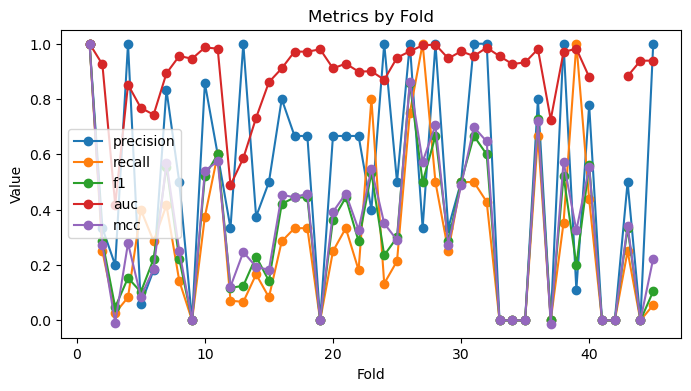

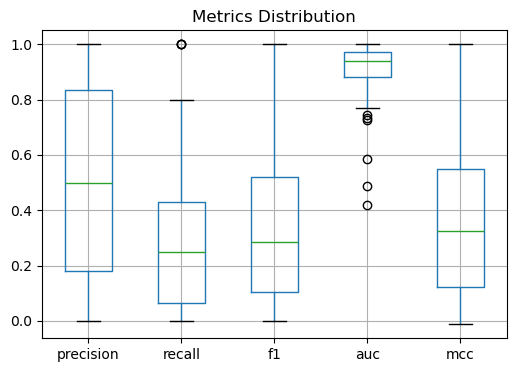

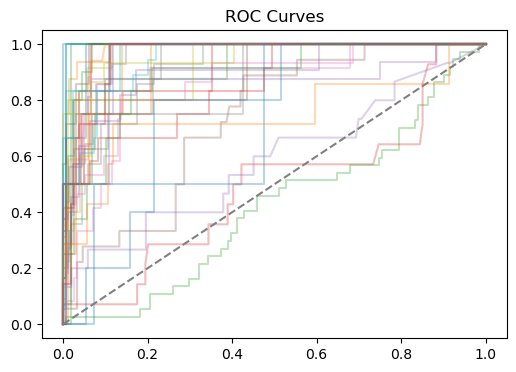

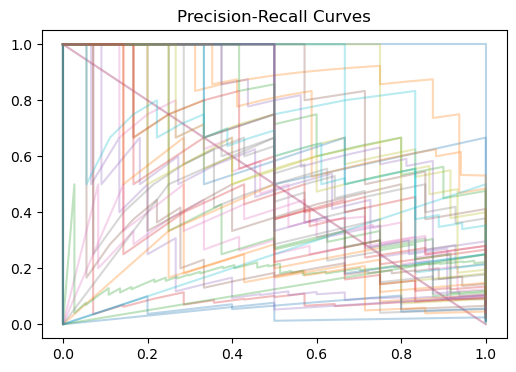

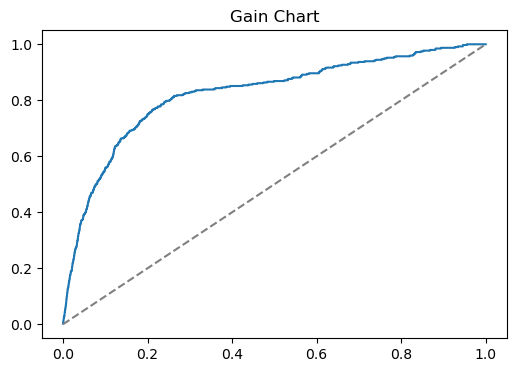

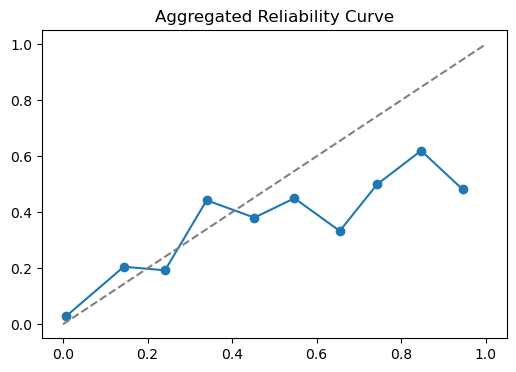


Per‑fold metrics:
      precision    recall        f1       auc       mcc
fold                                                   
1      1.000000  1.000000  1.000000  1.000000  1.000000
2      0.333333  0.250000  0.285714  0.925305  0.273760
3      0.200000  0.027027  0.047619  0.418403 -0.008553
4      1.000000  0.083333  0.153846  0.852030  0.279006
5      0.058824  0.400000  0.102564  0.768098  0.086146
6      0.181818  0.285714  0.222222  0.743567  0.185649
7      0.833333  0.416667  0.555556  0.893162  0.569345
8      0.500000  0.142857  0.222222  0.955634  0.251762
9      0.000000  0.000000  0.000000  0.945783  0.000000
10     0.857143  0.375000  0.521739  0.986431  0.541208
11     0.600000  0.600000  0.600000  0.982278  0.574684
12     0.333333  0.071429  0.117647  0.488868  0.121967
13     1.000000  0.066667  0.125000  0.586275  0.247139
14     0.375000  0.166667  0.230769  0.732407  0.193649
15     0.500000  0.083333  0.142857  0.861111  0.182659
16     0.800000  0.285714  0.

In [40]:
# List the test_reports folds
print("Found test folds:", sorted(p.name for p in Path("test_reports").iterdir() if p.is_dir()))

# Run consolidation
target = TARGETS[1]
df_test = consolidate_reports("logloss"+"/"+target)


# Inspect results
print("\nPer‑fold metrics:")
print(df_test.to_string())

print("\nSummary stats (mean ± std):")
print(df_test.agg(["mean","std"]).to_string())


In [37]:
aggregate_shap_summary(
    report_base_dir="logloss",
    targets=TARGETS,
    summary_plot_top_n=20
)

Saved SHAP summary plot for Price_positive_secondary -> logloss\Price_positive_secondary\shap_summary_Price_positive_secondary.png
Saved SHAP summary plot for Price_negative_secondary -> logloss\Price_negative_secondary\shap_summary_Price_negative_secondary.png
Saved SHAP summary plot for Price_positive_tertiary -> logloss\Price_positive_tertiary\shap_summary_Price_positive_tertiary.png
Saved SHAP summary plot for Price_negative_tertiary -> logloss\Price_negative_tertiary\shap_summary_Price_negative_tertiary.png


In [38]:
def plot_combined_importances(
    report_base_dir: str,
    targets: list[str],
    imp_type: str = "gain",
    top_n: int = 20
):
    """
    Aggregate importance_{imp_type}.csv across folds and targets,
    then plot a single vertical grouped bar chart:
      - X-axis: feature names
      - Y-axis: mean importance
      - One bar per target for each feature.
      - Legend placed inside plot.
    """
    base = Path(report_base_dir)
    combined = {}

    # 1) Collect per-target mean importances
    for target in targets:
        target_dir = base / target
        if not target_dir.exists():
            continue
        series_list = []
        for fold_dir in sorted(target_dir.iterdir()):
            if fold_dir.is_dir() and fold_dir.name.startswith("fold_"):
                imp_file = fold_dir / f"importance_{imp_type}.csv"
                if imp_file.exists():
                    df = pd.read_csv(imp_file, index_col=0)
                    series_list.append(df.iloc[:, 0])
        if series_list:
            mean_imp = pd.concat(series_list, axis=1).mean(axis=1)
            combined[target] = mean_imp

    if not combined:
        print("No importances found.")
        return

    # 2) Build DataFrame: features x targets
    df_combined = pd.DataFrame(combined).fillna(0)

    # 3) Select top_n features by max importance
    top_features = df_combined.max(axis=1).sort_values(ascending=False).head(top_n).index
    df_plot = df_combined.loc[top_features]

    # 4) Plot vertical grouped bar chart
    fig, ax = plt.subplots(figsize=(14, 8))
    df_plot.plot.bar(ax=ax)
    ax.set_xlabel("Feature")
    ax.set_ylabel("Mean Importance")
    ax.set_title(f"Top {top_n} Features: Mean {imp_type.capitalize()} Importance by Target")
    ax.legend(title="Target", loc='upper right', frameon=True)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

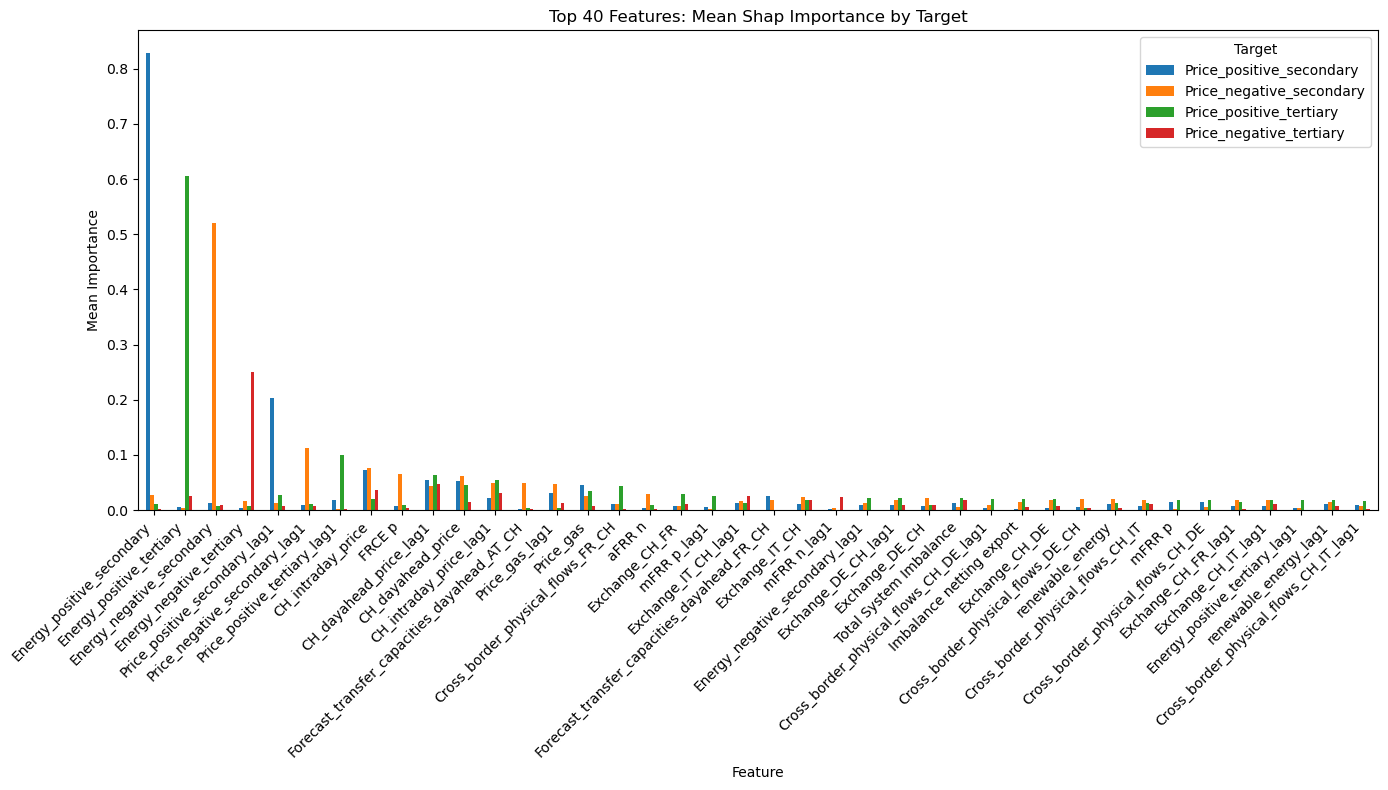

In [39]:
# Example usage:
plot_combined_importances("logloss", TARGETS, imp_type="shap", top_n=40)